In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F

In [3]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [ ]:
# imports for model changes
from src.methods.bayes.variational.net import NormalVarBayesModule

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:20<00:00, 474kB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 234kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 825kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.99MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Define parameters for training

In [ ]:
base_module = Classifier()

model = NormalVarBayesModule.from_module(base_module)

ReportChain([VarBaseReport()])

model, trainer = model.fit(train_dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/1],Loss:2142.981201171875, KL Loss: 186011.609375. FitLoss: 292.26934814453125,Accuracy:0.15381944444444445,Validation Loss:2020.1793212890625,Validation Accuracy:0.5875, Prune parameters: 603.0/421642,Beta: 0.01


In [22]:
from src.methods.report.base import ReportChain
from src.methods.report.visualise import VarPlotReport

report_chain = ReportChain([VarPlotReport(report_names=['total_loss', 'kl_loss', "accuracy"])])
trainer_params = { "num_epochs": 3,"beta": 0.01,"prune_threshold": -5,"num_samples": 1 }
model, trainer = model.fit(test_dataset, trainer_params=trainer_params, report_chain=report_chain)

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Show, that  trained model can be pruned well

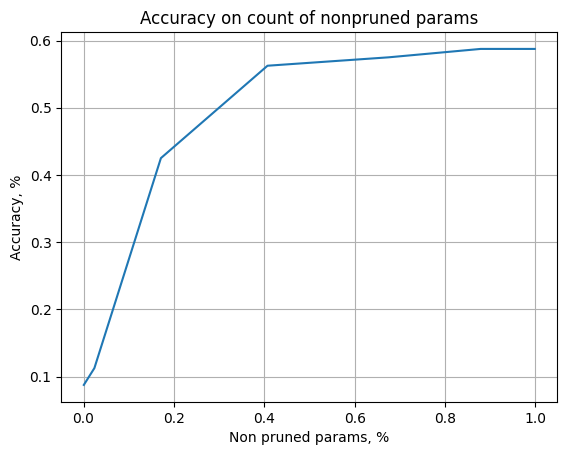

In [16]:
thresholds = np.linspace(-5, 5, 10)
threshold_results = trainer.eval_thresholds(model, thresholds)

# plot dependence of accuracy on count on non pruned parameter
x_s = [(a.cnt_prune_parameters / a.cnt_params).cpu().numpy() for a in threshold_results]
x_s = 1. - np.array(x_s) # now we get partition of non pruned parameters
y_s = [a.custom_losses["val_accuracy"] for a in threshold_results]

plt.plot(x_s, y_s)
plt.xlabel("Non pruned params, %")
plt.ylabel("Accuracy, %")
plt.title("Accuracy on count of nonpruned params")
plt.grid()